In [1]:
import nflgame

# returns the field position as the number of yards away from the opposing team's end zone
def field_pos_to_number(pos):
    pos = pos.split(" ")
    if pos[0] == "MIDFIELD":
        return 50
    elif pos[0] == "OWN":
        return 100-int(pos[1])
    elif pos[0] == "OPP":
        return int(pos[1])
    
# returns the current game clock as a quarter, clock tuple
def clock_to_nums(clock):
    clock = clock.split(" ")
    clock[0] = min(int(clock[0][1:]), 5)
    return clock[0], clock[1]

# returns the current play in a different format
def convert_play(p):
    quarter, time = clock_to_nums(p[2])
    return [quarter, time, p[3], p[4], field_pos_to_number(p[5]), p[-5], p[-4], p[-3], p[-2], p[-1]]
    
# get number of points scored on the conversion attempt after a touchdown
def get_conversion(plays, scores, i):
    # use list of scoring plays to figure out conversions
    if i < len(scores):
        #print(scores[i])
        if " TD " in scores[i]:
            if "failed" in scores[i]:
                return 0, i+1
            if "kick is good" in scores[i]:
                return 1, i+1
            if "run)" in scores[i] or "pass)" in scores[i]:
                return 2, i+1
            if i < len(scores)-1 and "defensive two point conversion" in scores[i+1]:
                return -1, i+2
    return 0, i+1

# get all plays for a given game in the proper format
def get_all_plays2(game, spread):   
    plays = nflgame.combine_plays([game])
    scores = game.scores
    score_index = 0
    home = 0
    away = 0
    win = (game.score_home >= game.score_away)
    plays2 = []
    for p in plays:
        plays2.append(p)

    all_plays = []
    for i in range(len(plays2)):
        p = plays2[i]
        if (p.down > 0 and str(p.time) != "None" and str(p.yardline) != "None"): # or p.note == "KICKOFF":
            # add play to all plays
            temp_play = [game.home, game.away, str(p.time), p.down, p.yards_togo, 
                         str(p.yardline), p.home, home, away, spread, win]
            all_plays.append(convert_play(temp_play))
#         if (not p.note == None) and len(p.note) >= 2 and (p.note[:2] == "2P" or p.note[:2] == "XP"):
#             print(p.note)
        # do scoring stuff
        if p.note == "TD":
            pts = 6
            is_home = p.home
            if p.punting_tot == 1:
                is_home = (not is_home)
            if p.defense_tds == 1:
                is_home = (not is_home)
#             is_home = True
#             if (not p.home and p.defense_tds != 1) or (p.home and p.defense_tds == 1):
#                 is_home = False
            conv, score_index = get_conversion(plays2, scores, score_index)
            # add conversion points if it wasn't a defensive 2 point conversion
            if conv != -1:
                pts += conv
            if is_home:
                home += pts
            else:
                away += pts
            # handle defensive 2 point conversion 
            if conv == -1:
                if is_home:
                    away += 2
                else:
                    home += 2
            #print(str(home) + "-" + str(away))

        elif p.note == "FG":
            if p.home:
                home += 3
            else:
                away += 3
            score_index += 1
                
        elif p.note == "SAF":
            if scores[score_index].split("-")[0][:-1] == str(game.home):
                home += 2
            else:
                away += 2
            score_index += 1

    return home, away, all_plays

def fix_name(t):
    if t == "SD":
        t = "LAC"
    if t == "LA" or t == "STL":
        t = "LAR"
    if t == "JAC":
        t = "JAX"
    return t

In [2]:
import pandas as pd

data = pd.read_csv("elo_and_vegas_spreads2.csv")

data = data.drop(data.columns[0], axis=1)
data = data[data["schedule_season"] >= 2009]
data = data[data["schedule_playoff"] == False]
data.drop(["schedule_playoff"],axis=1,inplace=True)

In [6]:
import matplotlib.pyplot as plt

# get all plays from all weeks in weeks and all seasons in years. calls get_all_plays2
def get_plays(years, weeks, indexes=-1):
    all_plays = []
    for y in years:
        print(y)
        for w in weeks:
            #print(w)
            try:
                games = nflgame.games(y, week=w, kind='REG')
            except:
                continue
            current = data[(data["schedule_season"] == y) & (data["schedule_week"] == str(w))]
            if not indexes == -1:
                games = [games[i] for i in indexes]
            for g in games:
                t1 = g.home
                t2 = g.away
                t1 = fix_name(t1)
                t2 = fix_name(t2)
                #print(t2)
                spread = list(current.loc[(current["team1"] == t1) & (current["team2"] == t2)]["vegas_spread"])
                if len(spread) > 0:
                    h, a, cur_plays = get_all_plays2(g, spread[0])
                    if h != g.score_home or a != g.score_away:
                        #print("Actual: " + str(g.score_home) + "-" + str(g.score_away) + ", Mine: " + str(h) + "-" + 
                          #    str(a) + " " + str(g.home) + " " +str(g.away))
                        continue
                    all_plays += cur_plays
    return all_plays

# final model?
def collect_plays(all_plays):
    # collect plays and add interaction terms
    x_data = []
    y_data = []
    for p in all_plays:
        qtr = p[0]
        time = p[1].split(":")
        if len(time[0]) == 0:
            continue
        mins_left = 15*(4-min(qtr,4))+int(time[0])
        secs_left = int(time[1])
        time_left = round(mins_left + secs_left/60.,2)

        x_data.append([time_left]+p[2:-1])
        y_data.append(1 if p[-1] else 0)

    df = pd.DataFrame(x_data, columns=["time", "down", "distance", "fieldpos", "homeposs", "score_home", 
                                      "score_away", "spread"])

    # basic terms
    df["scorediff"] = df["score_home"] - df["score_away"]
    df["down1"] = df["down"].apply(lambda x : 1 if x == 1 else 0)
    df["down2"] = df["down"].apply(lambda x : 1 if x == 2 else 0)
    df["down3"] = df["down"].apply(lambda x : 1 if x == 3 else 0)
    df["down4"] = df["down"].apply(lambda x : 1 if x == 4 else 0)
    df["homeposs"] = df["homeposs"].apply(lambda x : 1 if x else 0)
    
    # interaction terms
    df["down1*poss"] = df["down1"] * df["homeposs"]
    df["down2*poss"] = df["down2"] * df["homeposs"]
    df["down3*poss"] = df["down3"] * df["homeposs"]
    df["down4*poss"] = df["down4"] * df["homeposs"]
    df["distance*poss"] = df["distance"] * df["homeposs"]
    df["fieldpos*poss"] = df["fieldpos"] * df["homeposs"]
    
    # more interaction terms
    df["time*poss"] = (60-df["time"]) * df["homeposs"]
    df["time*spread"] = df["time"] * df["spread"]
    df["time*scorediff"] = (60-df["time"]) * df["scorediff"]
    df["fgrange"] = df["fieldpos"].apply(lambda x : 1 if x <= 35 else 0)
    df["fgrange*poss"] = df["fgrange"] * df["homeposs"]

    # additional terms
    df["last5"] = df["time"].apply(lambda x : 1 if x <= 5 else 0)
    df["close"] = df["scorediff"].apply(lambda x : 1 if abs(x) <= 8 else 0)
    df["last5min_close"] = df["last5"] * df["close"]
    df["last5min_close_poss"] = df["last5min_close"] * df["homeposs"]
    
    # score correction
    df["sqrt_time"] = df["time"].apply(lambda x : 1 + np.sqrt(x))
    df["score_correction"] = df["scorediff"] / df["sqrt_time"]
    
    df.drop(["score_correction", "homeposs", "down", "score_home", "score_away", "last5", 
             "close", "sqrt_time"], axis=1, inplace=True)
    
    return df, y_data

def remove_features(df):
    df.drop(["time*poss", "time*spread", "time*scorediff", "fgrange", "fgrange*poss", 
             "last5min_close", "last5min_close_poss"], axis=1, inplace=True)
    return df

def check_wp(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

def check_wp2(x, y, model, threshold):
    y_pred = model.predict(x)
    time_left = list(x["time"])
    
    results = []
    for i in range(len(y_pred)):
        if time_left[i] > 5:
            continue
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

# check accuracy using original mse thing
def check_model_accuracy(test_x, test_y, model, last5):
    x = np.arange(0,1.01,0.05)
    y = []
    ses = []
    se = 0
    for i in x:
        if not last5:
            cur_mean, cur_se = check_wp(test_x, test_y, model, i)
        else:
            cur_mean, cur_se = check_wp2(test_x, test_y, model, i)
        y.append(cur_mean)
        ses.append(cur_se)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)) + ", SE = " + str(round(cur_se, 3)))
        se += (cur_mean-i)**2

    print("")
    print("mse: " + str(se/len(x)))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy2(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_se, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        se += cur_se
        count += cur_num

    print("")
    print("brier score: " + str(se/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
def get_brier(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    errors = []
    
    y_pred = list(y_pred)
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
            errors.append((y[i]-y_pred[i])**2)
    #print(count)
    return np.mean(results), sum(errors), len(errors)

# check accuracy using the brier score
def check_model_accuracy_all(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy_times(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy_times_pca(old_old_test_x, old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_old_test_x["time"] <= start_time) & 
                               (old_old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()

In [4]:
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

train_fraction = 0.7

years = [i for i in range(2009,2019)]
weeks = [i for i in range(1,18)]
plays = get_plays(years,weeks)

x_data, y_data = collect_plays(plays)

# convert to lists, randomize
cols = list(x_data)
x_data = x_data.values.tolist()
alldata = list(zip(x_data, y_data))
random.shuffle(alldata)
x_data, y_data = zip(*alldata)
x_data = list(x_data)
y_data = list(y_data)

# simpler model
x_data2 = pd.DataFrame(data=np.array(x_data), columns=cols)
x_data2 = remove_features(x_data2)
cols2 = list(x_data2)
x_data2 = x_data2.values.tolist()

# take the appropriate training and testing sets
num_points = int(train_fraction*len(x_data))
train_x = pd.DataFrame(x_data[:num_points], columns=cols)
train_y = y_data[:num_points]
test_x = pd.DataFrame(x_data[num_points:], columns=cols)
test_y = y_data[num_points:]

# training and testing for simpler model
train_x2 = pd.DataFrame(x_data2[:num_points], columns=cols2)
test_x2 = pd.DataFrame(x_data2[num_points:], columns=cols2)

/Users/Bill/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


## logistic models

In [5]:
logit_model=sm.Logit(train_y, train_x2)
result=logit_model.fit() # simplified model
logit_model=sm.Logit(train_y, train_x)
result2=logit_model.fit() # more complex model

temp = pd.concat([train_x2, pd.DataFrame(data=train_y, columns=["y"])], axis=1)
train_x_last5 = temp[temp["time"] <= 5]
train_y_last5 = train_x_last5["y"].tolist()
train_x_last5.drop(["y"], axis=1, inplace=True)

logit_model=sm.Logit(train_y_last5, train_x_last5)
result3=logit_model.fit() # logistic on only last 5 minutes

print(result.summary2())
print(result2.summary2())
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.457380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449440
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.258878
         Iterations 9
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.329      
Dependent Variable: y                AIC:              240659.3373
Date:               2020-03-06 16:11 BIC:              240816.5389
No. Observations:   263052           Log-Likelihood:   -1.2031e+05
Df Model:           14               LL-Null:          -1.7937e+05
Df Residuals:       263037           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z| 

/Users/Bill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## random forest models

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# regressor = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10)
# regressor.fit(train_x2, train_y) # use training data w/fewer features

# fit model 
regressor2 = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10)
regressor2.fit(train_x, train_y) # pca model with num_comp principal components

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

simplified logistic full game
0.0: 0.0
0.05: 0.035
0.1: 0.105
0.15: 0.156
0.2: 0.208
0.25: 0.251
0.3: 0.313
0.35: 0.364
0.4: 0.412
0.45: 0.44
0.5: 0.496
0.55: 0.558
0.6: 0.581
0.65: 0.649
0.7: 0.705
0.75: 0.745
0.8: 0.813
0.85: 0.849
0.9: 0.893
0.95: 0.951
1.0: 1.0

mse: 8.055592858527632e-05
brier score: 0.14713508040032194


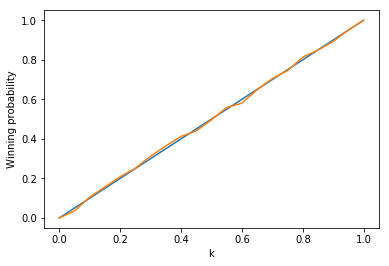

simplified logistic last 5
0.0: 0.0
0.05: 0.0
0.1: 0.022
0.15: 0.015
0.2: 0.145
0.25: 0.195
0.3: 0.205
0.35: 0.314
0.4: 0.381
0.45: 0.468
0.5: 0.546
0.55: 0.671
0.6: 0.624
0.65: 0.673
0.7: 0.728
0.75: 0.791
0.8: 0.889
0.85: 0.957
0.9: 0.977
0.95: 0.991
1.0: 1.0

mse: 0.004324006361444313
brier score: 0.09345649707408583


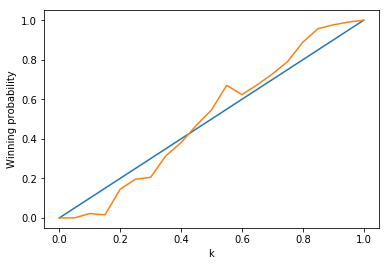

full logistic full game
0.0: 0.0
0.05: 0.038
0.1: 0.102
0.15: 0.164
0.2: 0.216
0.25: 0.261
0.3: 0.294
0.35: 0.371
0.4: 0.404
0.45: 0.447
0.5: 0.51
0.55: 0.565
0.6: 0.606
0.65: 0.644
0.7: 0.705
0.75: 0.758
0.8: 0.805
0.85: 0.86
0.9: 0.898
0.95: 0.943
1.0: 1.0

mse: 9.058211463513772e-05
brier score: 0.1399536948676787


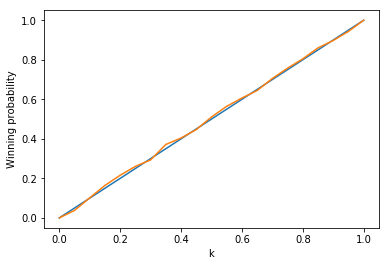

full logistic last 5
0.0: 0.0
0.05: 0.013
0.1: 0.051
0.15: 0.074
0.2: 0.15
0.25: 0.224
0.3: 0.264
0.35: 0.39
0.4: 0.393
0.45: 0.408
0.5: 0.536
0.55: 0.614
0.6: 0.683
0.65: 0.707
0.7: 0.673
0.75: 0.817
0.8: 0.829
0.85: 0.905
0.9: 0.944
0.95: 0.986
1.0: 1.0

mse: 0.002157217489228077
brier score: 0.07504974421527603


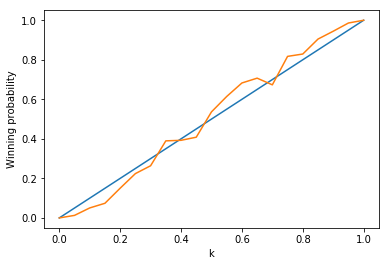

simplified forests full game
0.0: 0.0
0.05: 0.018
0.1: 0.047
0.15: 0.123
0.2: 0.167
0.25: 0.219
0.3: 0.273
0.35: 0.347
0.4: 0.408
0.45: 0.456
0.5: 0.513
0.55: 0.539
0.6: 0.602
0.65: 0.672
0.7: 0.709
0.75: 0.758
0.8: 0.814
0.85: 0.878
0.9: 0.939
0.95: 0.978
1.0: 0.999

mse: 0.0005615238902912585
brier score: 0.09504996578209643


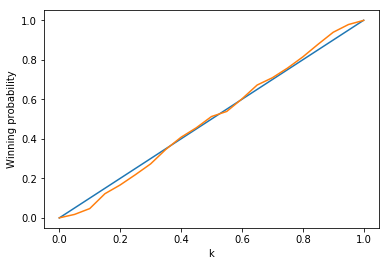

simplified forests last 5
0.0: 0.0
0.05: 0.012
0.1: 0.053
0.15: 0.122
0.2: 0.177
0.25: 0.211
0.3: 0.25
0.35: 0.379
0.4: 0.326
0.45: 0.576
0.5: 0.564
0.55: 0.542
0.6: 0.667
0.65: 0.728
0.7: 0.679
0.75: 0.764
0.8: 0.871
0.85: 0.892
0.9: 0.954
0.95: 0.996
1.0: 1.0

mse: 0.002778024927902432
brier score: 0.03962366331953988


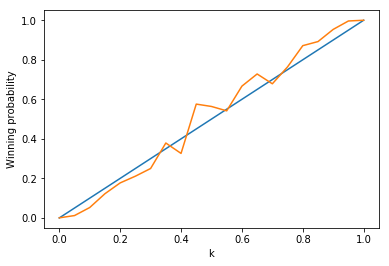

full forests full game
0.0: 0.001
0.05: 0.019
0.1: 0.048
0.15: 0.102
0.2: 0.144
0.25: 0.216
0.3: 0.288
0.35: 0.306
0.4: 0.383
0.45: 0.441
0.5: 0.498
0.55: 0.541
0.6: 0.591
0.65: 0.661
0.7: 0.735
0.75: 0.752
0.8: 0.832
0.85: 0.887
0.9: 0.938
0.95: 0.976
1.0: 0.999

mse: 0.0008926504299140215
brier score: 0.09498981951881696


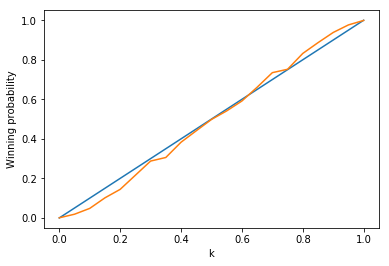

full forests last 5
0.0: 0.001
0.05: 0.015
0.1: 0.044
0.15: 0.148
0.2: 0.175
0.25: 0.143
0.3: 0.282
0.35: 0.275
0.4: 0.366
0.45: 0.541
0.5: 0.6
0.55: 0.613
0.6: 0.522
0.65: 0.656
0.7: 0.814
0.75: 0.765
0.8: 0.856
0.85: 0.879
0.9: 0.961
0.95: 0.99
1.0: 1.0

mse: 0.003543138560112761
brier score: 0.040129903568907464


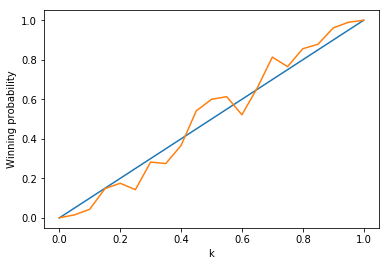

In [13]:
print("simplified logistic full game")
check_model_accuracy_times(test_x2, test_y, result, 60, 0)

print("simplified logistic last 5")
check_model_accuracy_times(test_x2, test_y, result, 5, 0)

print("full logistic full game")
check_model_accuracy_times(test_x, test_y, result2, 60, 0)

print("full logistic last 5")
check_model_accuracy_times(test_x, test_y, result2, 5, 0)

print("simplified forests full game")
check_model_accuracy_times(test_x2, test_y, regressor, 60, 0)

print("simplified forests last 5")
check_model_accuracy_times(test_x2, test_y, regressor, 5, 0)

print("full forests full game")
check_model_accuracy_times(test_x, test_y, regressor2, 60, 0)

print("full forests last 5")
check_model_accuracy_times(test_x, test_y, regressor2, 5, 0)